In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Importing Dataset

In [31]:
df = pd.read_csv('Dataset.csv')

#### 1. Dataset

i. This dataset is publicly available and is developed, maintained, and managed by **Health Canada**.

ii. It contains data dating back to 2016, when it was first reported, and is updated annually. The dataset can be accessed [here](https://health-infobase.canada.ca/substance-related-harms/opioids-stimulants/).

iii. Users can select between Opioids and Stimulants as the focus of analysis. For this project, both categories will be utilized.

iv. The dataset includes information on hospitalizations, emergency department visits, Emergency Medical Services (EMS) responses, and fatalities. Data is available by year or quarter and can be segmented by age group, gender, or a combination of both.

v. Three calculation methods are available:
* _Crude Rate_: Expressed per 100,000 people, commonly used for provincial-level data.
* _Percent_: Represents the proportion within a specific group and event.
* _Number_: The total count of cases within a given group and event.

#### 2. Data Wrangling

Before starting the analysis, we will make some adjustments to the data to improve readability, visualization and to make it easier to understand.

**1.** We will group smaller provinces within their geography. New Brunswick, Nova Scotia, Prince Edward Island and Newfoundland and Labrador will be grouped as _Atlantic Canada_ and Northwest Territories, Nunavut and Yukon will be grouped as _Canadian Territories_.

**2.** The column PRUID will be dropped as contains only an ID related to the column 'Type Event'

**3.** Some Data were supressed by the Provincial/Federal Governments and appear as "Suppr." on the column 'Value'. We will drop these rows as they have no valuable data.

**4.** We will split the datasets into Opioids and Stimulants, as each group of substance will be compared separately.

In [12]:
df['Region'].unique()

array(['Canada', 'British Columbia', 'Alberta', 'Saskatchewan',
       'Manitoba', 'Ontario', 'Quebec', 'New Brunswick', 'Nova Scotia',
       'Prince Edward Island', 'Newfoundland and Labrador', 'Yukon',
       'Northwest Territories', 'Nunavut', 'Territories',
       'Winnipeg, Manitoba', 'Northern and rural Manitoba',
       'Whitehorse, Yukon', 'Yellowknife, Northwest Territories'],
      dtype=object)

In [32]:
#Dropping PRUID
df = df.drop(['PRUID'],axis=1)

In [33]:
#Grouping Provinces by their Geography
df['Region'] = df['Region'].replace(['New Brunswick', 'Nova Scotia','Prince Edward Island', 'Newfoundland and Labrador'], 'Atlantic Canada')
df['Region'] = df['Region'].replace(['Yukon','Northwest Territories', 'Nunavut', 'Territories'], 'Canadian Territories')

In [40]:
#Dropping rows with Suppressed values
df = df.loc[df['Value'] != 'Suppr.']

In [56]:
#Adjusting the Data Type for 'Value' column
df['Value'] = df['Value'].astype('float')

C:\Users\jbertti\AppData\Local\Temp\ipykernel_37268\2751274160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'] = df['Value'].astype('float')


#### 3. Exploratory Data Analysis (EDA)

#### Guiding Question 1: What is the growth percentage of incidents by Province from 2016 to 2023?

In [113]:
gq1_o = df.loc[(df['Type_Event'] == 'Total apparent opioid toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids')]
gq1_s = df.loc[(df['Type_Event'] == 'Total apparent stimulant toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants')]

In [114]:
gq1_o = pd.pivot_table(data=gq1_o,index='Region',columns='Year_Quarter',values='Value',aggfunc='sum').reset_index()
gq1_s = pd.pivot_table(data=gq1_s,index='Region',columns='Year_Quarter',values='Value',aggfunc='sum').reset_index()

To perform a better analysis and answer this question, lets calculate the **Compound Annual Growth Rate (CAGR)**. This tool is useful when we want to perform a study with a determined variable over time, specially when the value of the time-series data are independent in time.

The CAGR is determined by:

$$
CAGR = \left( \frac{V_f}{V_i} \right)^{\frac{1}{n}}-1
$$

Where:
- $( V_{f} )$ = Final Value (e.g., value in 2023)
- $( V_{i} )$ = Initial Value (e.g., value in 2016)
- $( n )$ = Number of years


In [115]:
#Calculating the Compound Annual Growth Rate
gq1_o['CAGR'] = ((gq1_o['2023']/gq1_o['2016'])**(1/8))-1
gq1_s['CAGR'] = ((gq1_s['2021']/gq1_s['2018'])**(1/4))-1

In [118]:
#Adjusting the Calculation of the CAGR due to inconsistencies on the data
gq1_s.loc[gq1_s['Region'] == 'Quebec', 'CAGR'] = ((gq1_s['2021']/gq1_s['2018'])**(1/4))-1
gq1_s.loc[gq1_s['Region'] == 'Manitoba', 'CAGR'] = ((gq1_s['2023']/gq1_s['2019'])**(1/5))-1
gq1_s.loc[gq1_s['Region'] == 'Canadian Territories', 'CAGR'] = ((gq1_s['2023']/gq1_s['2020'])**(1/4))-1

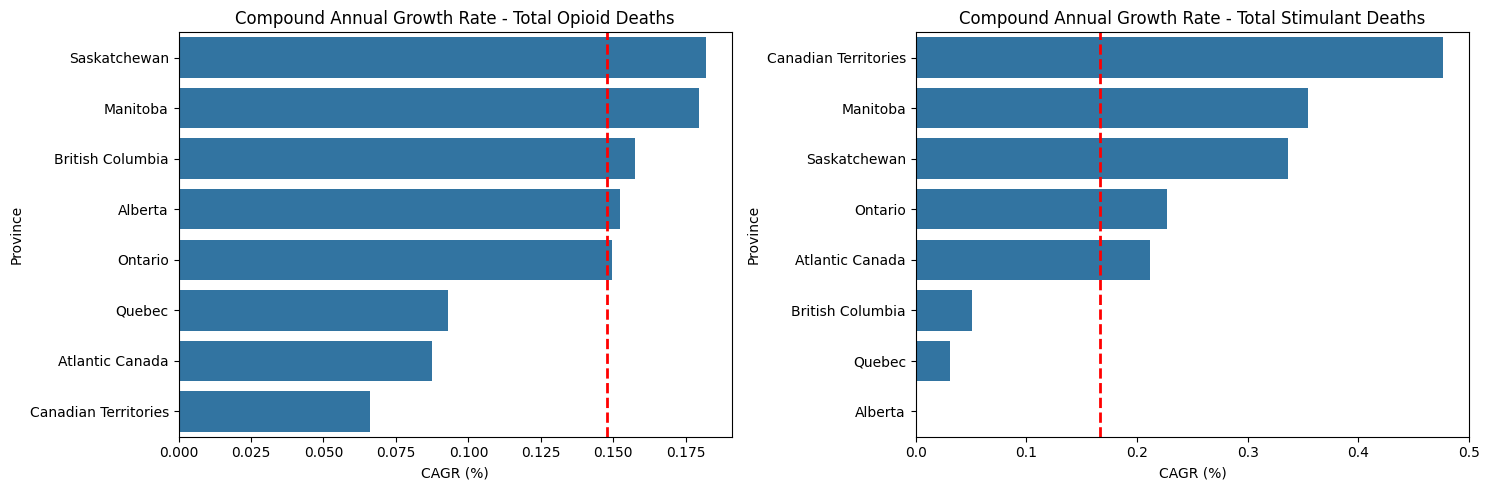

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=gq1_o.loc[gq1_o['Region'] != 'Canada'].sort_values(by='CAGR',ascending=False),x='CAGR',y='Region',ax=axes[0])
axes[0].set_title('Compound Annual Growth Rate - Total Opioid Deaths')
axes[0].set_xlabel('CAGR (%)')
axes[0].set_ylabel('Province')
canada_cagr = gq1_o.loc[gq1_o['Region'] == 'Canada', 'CAGR'].values[0]
axes[0].axvline(x=canada_cagr, color="red", linewidth=2, linestyle='--')

sns.barplot(data=gq1_s.loc[gq1_s['Region'] != 'Canada'].sort_values(by='CAGR',ascending=False),x='CAGR',y='Region',ax=axes[1])
axes[1].set_title('Compound Annual Growth Rate - Total Stimulant Deaths')
axes[1].set_xlabel('CAGR (%)')
axes[1].set_ylabel('Province')
canada_cagr_s = gq1_s.loc[gq1_o['Region'] == 'Canada', 'CAGR'].values[0]
axes[1].axvline(x=canada_cagr_s, color="red", linewidth=2, linestyle='--')
plt.tight_layout()

The charts above display the **Compound Annual Growth Rate (CAGR)** for opioid and stimulant deaths across Canadian provinces from 2016 to 2023. The **<span style="color: navy;">blue bars</span>** represent the growth rate for each province, and the **<span style="color: red;">red line</span>** shows the national rate for Canada.

##### **Opioids**:
The highest growth in opioid deaths occurred in Manitoba and Saskatchewan, with a CAGR of about 17.5%.

Three provinces with a large population share — Alberta (AB), British Columbia (BC), and Ontario (ON) — had growth rates of around 15%. Quebec, despite being the third most populous, saw growth similar to smaller regions like Atlantic Canada and the Territories - approximately 10%. Nationally, Canada’s CAGR for opioid deaths from 2016 to 2023 was 14.8%.

##### **Stimulants:**
Stimulant data posed challenges as Alberta didn’t report, Quebec stopped in 2021, and Manitoba only began reporting in 2019. Therefore, CAGR calculations were adjusted for these reporting gaps.

Similar to opioids, stimulant-related deaths were notably higher in Central Canada, where growth rates exceeded 30%. Nationally, Canada’s stimulant death growth was about half that rate. British Columbia and Quebec were exceptions, with growth rates under 5%. Canadian Territories figures while concerning, have to be taken with caution because the size of the sample and population, but a 45% Growth increase is always concerning.

This highlights regional differences in stimulant-related deaths, with Central Canada seeing the largest increases, while British Columbia and Quebec experienced more less aggressive trends.

#### Guiding Question 2: Is there a specific group (Age, Sex) in which the growth was more prevalent?

##### Overall - Age Group and Gender

In [239]:
gq2_o_overall = df.loc[(df['Type_Event'] == 'Total apparent opioid toxicity deaths') & (df['Unit'] == 'Percent') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]
gq2_s_overall = df.loc[(df['Type_Event'] == 'Total apparent stimulant toxicity deaths') & (df['Unit'] == 'Percent') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants')& (df['Year_Quarter'] != '2024 (Jan to Jun)')]

In [240]:
age_groups = ['0 to 19 years', '20 to 29 years','30 to 39 years', '40 to 49 years', '50 to 59 years','60 years or more']
gq2_o_age = gq2_o_overall.loc[gq2_o_overall['Disaggregator'].isin(age_groups)]
gq2_s_age = gq2_s_overall.loc[gq2_s_overall['Disaggregator'].isin(age_groups)]

In [241]:
genders = ['Male','Female']
gq2_o_gender = gq2_o_overall.loc[gq2_o_overall['Disaggregator'].isin(genders)]
gq2_s_gender = gq2_s_overall.loc[gq2_s_overall['Disaggregator'].isin(genders)]

In [242]:
gq2_o_age = pd.pivot(data=gq2_o_age,index='Disaggregator',columns='Year_Quarter',values='Value').reset_index()
gq2_s_age = pd.pivot(data=gq2_s_age,index='Disaggregator',columns='Year_Quarter',values='Value').reset_index()
gq2_o_age = gq2_o_age.set_index('Disaggregator')
gq2_s_age = gq2_s_age.set_index('Disaggregator')

gq2_o_gender = pd.pivot(data=gq2_o_gender,index='Disaggregator',columns='Year_Quarter',values='Value').reset_index()
gq2_s_gender = pd.pivot(data=gq2_s_gender,index='Disaggregator',columns='Year_Quarter',values='Value').reset_index()
gq2_o_gender = gq2_o_gender.set_index('Disaggregator')
gq2_s_gender = gq2_s_gender.set_index('Disaggregator')

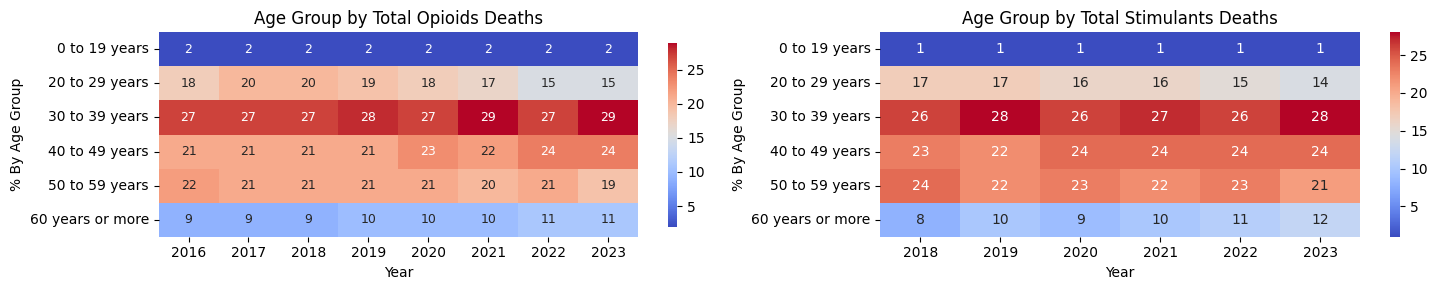

In [258]:
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 3))

sns.heatmap(data=gq2_o_age,cmap='coolwarm',ax=axes2[0],annot=True,annot_kws={"size": 9}, cbar_kws={'shrink': 0.9})
axes2[0].set_title('Age Group by Total Opioids Deaths')
axes2[0].set_ylabel('% By Age Group')
axes2[0].set_xlabel('Year')

sns.heatmap(data=gq2_s_age,cmap='coolwarm',ax=axes2[1],annot=True)
axes2[1].set_title('Age Group by Total Stimulants Deaths')
axes2[1].set_ylabel('% By Age Group')
axes2[1].set_xlabel('Year')

plt.tight_layout()

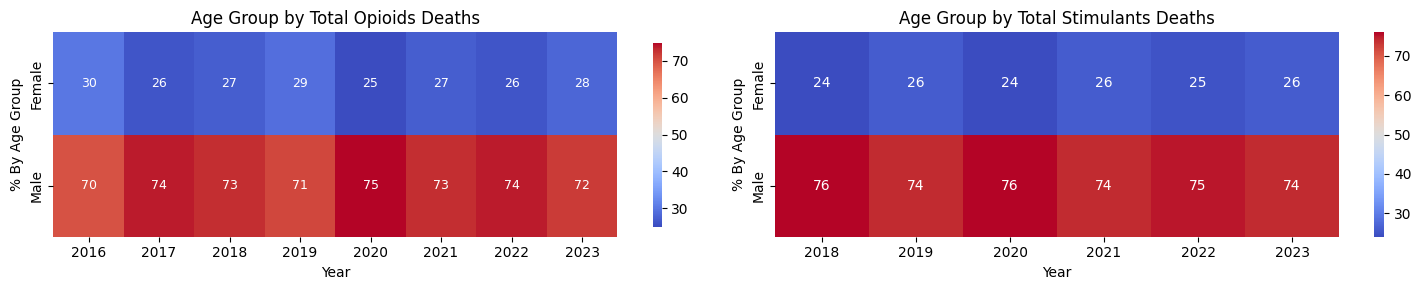

In [259]:
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 3))

sns.heatmap(data=gq2_o_gender,cmap='coolwarm',ax=axes2[0],annot=True,annot_kws={"size": 9}, cbar_kws={'shrink': 0.9})
axes2[0].set_title('Gender by Total Opioids Deaths')
axes2[0].set_ylabel('% By Gender')
axes2[0].set_xlabel('Year')

sns.heatmap(data=gq2_s_gender,cmap='coolwarm',ax=axes2[1],annot=True)
axes2[1].set_title('Gender by Total Stimulants Deaths')
axes2[1].set_ylabel('% By Gender')
axes2[1].set_xlabel('Year')

plt.tight_layout()

#### **Age Group**

The data indicates that individuals aged **30 to 39 years** are the most affected, followed closely by those aged **40 to 49 years**. Notably, the presence of **young adults (0–19 years)** in these statistics is concerning, with **2% of opioid-related cases and 1% of stimulant-related cases**. Additionally, there is a growing impact on the **60+ age group**, with opioid-related cases rising from **9% in 2016 to 11% in 2023**. The trend is even more pronounced for stimulants, where cases in this age group increased by **50% (from 8% to 12%)**. Given the overall rise in substance-related deaths, the **increasing impact on both older adults and younger individuals** is a significant public health concern.

#### **Gender**

There is a clear **male predominance** in substance-related deaths, with males **consistently representing over 70%** of cases. While opioid-related fatalities among females declined slightly from **30% in 2016 to 28% in 2023**, the opposite trend is observed for stimulants, where the proportion of female cases increased **from 24% in 2018 to 26%** in 2023.

In response to **Guiding Question #2**, the data confirms that **males and middle-aged adults (30–39 years)** remain the most affected groups. However, there is also a **notable rise in fatalities among older adults and young individuals**, indicating a broadening impact across different demographics.

##### Age Group By Gender

In [360]:
gq2_o_2 = df.loc[(df['Type_Event'] == 'Accidental apparent opioid toxicity deaths') & (df['Specific_Measure'] == 'Age group by sex') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]
gq2_s_2 = df.loc[(df['Type_Event'] == 'Accidental apparent stimulant toxicity deaths') & (df['Specific_Measure'] == 'Age group by sex') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]

In [361]:
gq2_o_2 = gq2_o_2[['Disaggregator','Aggregator','Year_Quarter','Value']].groupby(by=['Disaggregator','Aggregator','Year_Quarter']).sum().reset_index()
gq2_s_2 = gq2_s_2[['Disaggregator','Aggregator','Year_Quarter','Value']].groupby(by=['Disaggregator','Aggregator','Year_Quarter']).sum().reset_index()

In [363]:
gq2_o_2['%'] = gq2_o_2['Value']/gq2_o_2.groupby(by=['Aggregator','Year_Quarter'])['Value'].transform('sum')
gq2_s_2['%'] = gq2_s_2['Value']/gq2_s_2.groupby(by=['Aggregator','Year_Quarter'])['Value'].transform('sum')

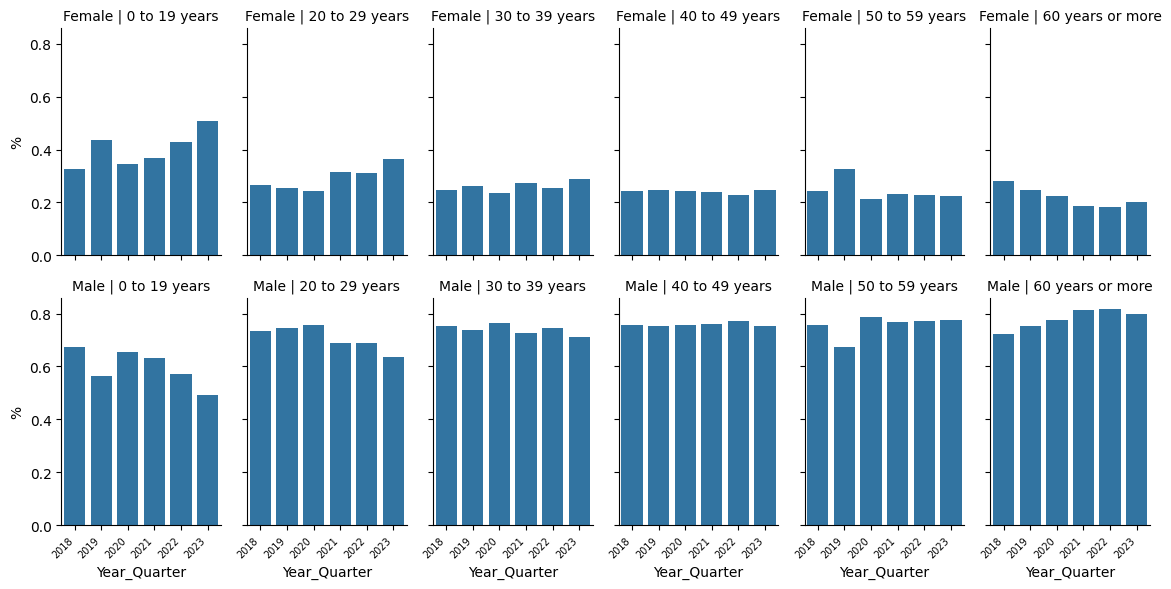

In [364]:
g = sns.FacetGrid(data=gq2_o_2,col='Aggregator',row='Disaggregator',aspect=.65)
g.map_dataframe(sns.barplot, x="Year_Quarter",y='%')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7) 

plt.tight_layout()

##### **Opioid Deaths Sliced by Gender and Age Group**


The charts above illustrate that the **30-39 and 40-49 age groups are predominantly male**, consistently accounting for over 80% of victims. This aligns with earlier findings on age and gender distribution.

However, the proportion of **female victims** in younger age groups has risen significantly in recent years. In the youngest group, the female share increased from 25% to over 50%, while in the next group, it grew from 22% to nearly 40%. Among those aged 60 and older, the percentage of female victims increased in 2023 compared to 2022 but remains lower than in the early years of the dataset, when it was around 25%.

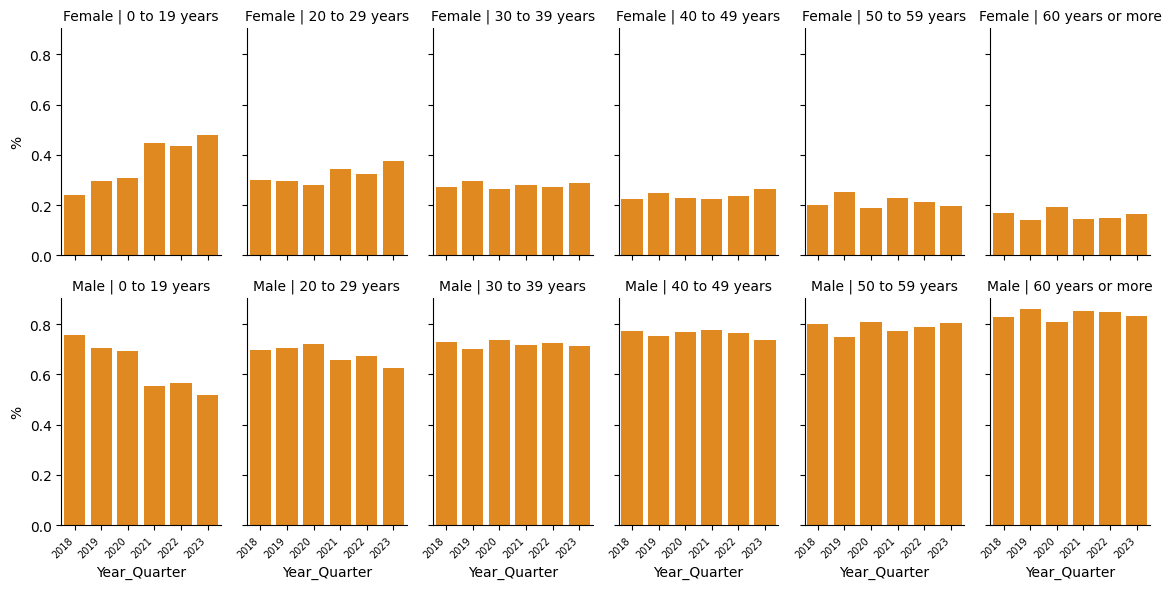

In [366]:
g = sns.FacetGrid(data=gq2_s_2,col='Aggregator',row='Disaggregator',aspect=.65)
g.map_dataframe(sns.barplot, x="Year_Quarter",y='%',color='darkorange')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7) 

plt.tight_layout()

##### **Stimulant Deaths Sliced by Gender and Age Group**

Similar to Opioids, Stimulant-related deaths among females have increased in younger age groups. The percentage of female victims in the 0-19 age group doubled, rising from 24% to 48.1%, while the 20-29 group saw an increase from 30% to 37%. In contrast, other age groups remain largely male-dominated with consistent averages over time.

#### Guiding Question 3: Is the weather relevant for the number of incidents?

#### Guiding Question 4: What is the share of intentional deaths/hospitalizations overall? Is it increasing or decreasing?

In [525]:
gq4_o_deaths = df.loc[(df['Type_Event'] == 'Total apparent opioid toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids') & (df['Year_Quarter'] != '2024 (Jan to Jun)') & (df['Specific_Measure'] == 'Overall numbers')]
gq4_o_hosp = df.loc[(df['Type_Event'] == 'Total opioid-related poisoning hospitalizations') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids') & (df['Year_Quarter'] != '2024 (Jan to Jun)') & (df['Specific_Measure'] == 'Overall numbers')]

gq4_s_deaths = df.loc[(df['Type_Event'] == 'Total apparent stimulant toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants') & (df['Year_Quarter'] != '2024 (Jan to Jun)') & (df['Specific_Measure'] == 'Overall numbers')]
gq4_s_hosp = df.loc[(df['Type_Event'] == 'Total stimulant-related poisoning hospitalizations') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants') & (df['Year_Quarter'] != '2024 (Jan to Jun)') & (df['Specific_Measure'] == 'Overall numbers')]

In [527]:
gq4_o_deaths = gq4_o_deaths[['Year_Quarter','Region','Value']]
gq4_o_deaths.columns = ['Year','Region','Deaths']
gq4_o_hosp = gq4_o_hosp[['Year_Quarter','Region','Value']]
gq4_o_hosp.columns = ['Year','Region','Hospitalizations']
gq4_o_final = gq4_o_deaths.merge(gq4_o_hosp,on=['Year','Region'],how='inner')

gq4_s_deaths = gq4_s_deaths[['Year_Quarter','Region','Value']]
gq4_s_deaths.columns = ['Year','Region','Deaths']
gq4_s_hosp = gq4_s_hosp[['Year_Quarter','Region','Value']]
gq4_s_hosp.columns = ['Year','Region','Hospitalizations']
gq4_s_final = gq4_s_deaths.merge(gq4_s_hosp,on=['Year','Region'],how='inner')

In [528]:
gq4_o_final['%'] = gq4_o_final['Deaths']/gq4_o_final['Hospitalizations']
gq4_s_final['%'] = gq4_s_final['Deaths']/gq4_s_final['Hospitalizations']

In [529]:
gq4_o_final = gq4_o_final.groupby(['Year', 'Region'], as_index=False)['%'].mean()
gq4_o_final = pd.pivot(data=gq4_o_final, index='Region', columns='Year', values='%').reset_index()
gq4_o_final = gq4_o_final.set_index('Region')

gq4_s_final = gq4_s_final.groupby(['Year', 'Region'], as_index=False)['%'].mean()
gq4_s_final = pd.pivot(data=gq4_s_final, index='Region', columns='Year', values='%').reset_index()
gq4_s_final = gq4_s_final.set_index('Region')

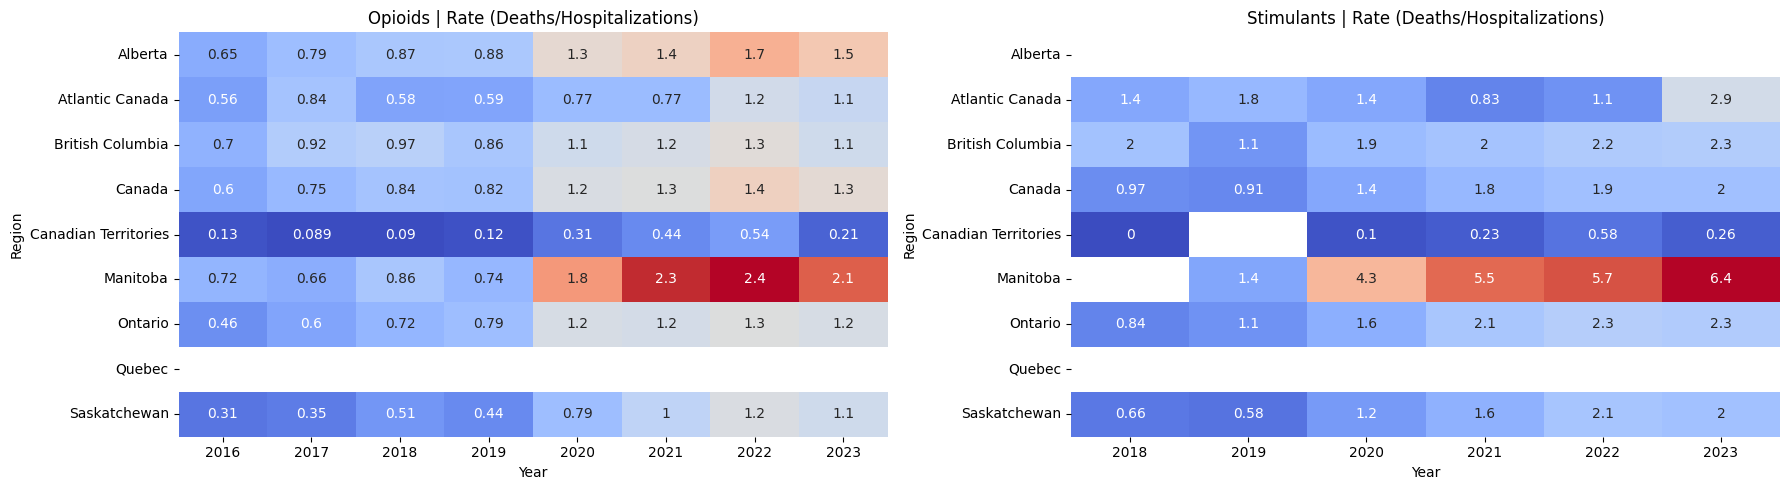

In [538]:
fig3, axes3 = plt.subplots(1, 2, figsize=(18, 5))

sns.heatmap(data=gq4_o_final,cmap='coolwarm',ax=axes3[0],annot=True,cbar=False)
axes3[0].set_title('Opioids | Rate (Deaths/Hospitalizations)')
axes3[0].set_ylabel('Region')
axes3[0].set_xlabel('Year')

sns.heatmap(data=gq4_s_final,cmap='coolwarm',ax=axes3[1],annot=True,cbar=False)
axes3[1].set_title('Stimulants | Rate (Deaths/Hospitalizations)')
axes3[1].set_ylabel('Region')
axes3[1].set_xlabel('Year')

plt.tight_layout()


The **death-to-hospitalization rate** is a critical metric for understanding the trajectory of this crisis. While we observe growth in this rate (as shown on Guiding Question #1), **a rate lower than 1 suggests that hospitalizations are outpacing deaths**, offering a chance to save more lives. However, the data from the past three years across all regions, including Canada, indicates that the rate has consistently exceeded 1 in all provinces except Territories. **For instance, in 2023, Manitoba had twice as many deaths as hospitalizations, while Alberta had a rate of 1.5.**

A concerning trend is the increase in this rate across all regions from 2016 to 2023, especially during the pandemic years (2020-2022). This points to a worsening situation that will likely be more difficult to control than before. Education on harm reduction and guidance on treatment options in hospitals and other healthcare facilities are key to reducing this rate, saving lives, and improving the overall situation.

The trend for **stimulants follows a similar pattern, but with even more alarming figures**. All regions that reported data (except for the Territories) have a death-to-hospitalization rate higher than 2, indicating that fatalities are twice as frequent as hospitalizations, with little chance for intervention. **Manitoba, in particular, stands out as the most affected province on both fronts.**

In [ ]:
#Next topics:
#### Death-to-Hospitalization Rate by Age Group and Gender
#### RACE Chart by Quarter and Province of Deaths